# Projekt 1, kamień milowy 2
## Sebastian Deręgowski, Dawid Janus

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

In [3]:
voices_get = requests.get("https://api.apispreadsheets.com/api/dataset/gender-voice/")
voices_dict = voices_get.json()
voices_df = pd.json_normalize(voices_dict, 'data')

## Inżynieria cech

Usuwamy kolumny *kurt*, *centroid* oraz *dfrange* ze względu na to, że są parami zkolerowane z innymi kolumnami (wspołczynnik korelacji jest większy niz 0.99) 

In [4]:
voices_df.drop(columns=['kurt','centroid','dfrange'])

,meanfreq,sd,median,Q25,Q75,IQR,skew,sp.ent,sfm,mode,meanfun,minfun,maxfun,meandom,mindom,maxdom,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,0.893369,0.491918,0.000000,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,0.892193,0.513724,0.000000,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,0.846389,0.478905,0.000000,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,0.963322,0.727232,0.083878,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,0.971955,0.783568,0.104261,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,0.208274,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3163,0.131884,0.084734,0.153707,0.049285,0.201144,0.151859,1.762129,0.962934,0.763182,0.200836,0.182790,0.083770,0.262295,0.832899,0.007812,4.210938,0.161929,female
3164,0.116221,0.089221,0.076758,0.042718,0.204911,0.162193,0.693730,0.960716,0.709570,0.013683,0.188980,0.034409,0.275862,0.909856,0.039062,3.679688,0.277897,female
3165,0.142056,0.095798,0.183731,0.033424,0.224360,0.190936,1.876502,0.946854,0.654196,0.008006,0.209918,0.039506,0.275862,0.494271,0.007812,2.937500,0.194759,female
3166,0.143659,0.090628,0.184976,0.043508,0.219943,0.176435,1.591065,0.950436,0.675470,0.212202,0.172375,0.034483,0.250000,0.791360,0.007812,3.593750,0.311002,female


Dla zmiennej *skew* zastosowaliśmy transformację logarytmiczyną, ze względu na tak zwany "długi ogon".

In [5]:
voices_df['skew'] = np.log1p(voices_df['skew'])

Dla zmiennej *label* zastosowaliśmy encoding zamieniając zmienną kategoryczną na numeryczną.

In [6]:
voices_df['label']=voices_df['label'].replace('male',1)
voices_df['label']=voices_df['label'].replace('female',0)

Na koniec zapisujemy naszą ramke danych do pliku csv w celu wygodniejszej pracy z nią w przyszłości.

In [7]:
voices_df.to_csv('voices.csv',header=True,index=False)
voices_df = pd.read_csv("voices.csv")

## Wstępne modele

### Stworzenie zbioru treningowego i testowego

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(voices_df[voices_df.columns.values[:-1]],voices_df[voices_df.columns.values[-1]],random_state=40,test_size=0.33)

Stworzymy trzy modele: regresji logistycznej, k-Nearest Neighbors oraz XGBoost, a następnie porównamy ich wyniki:

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier

lr = LogisticRegression()
lr.fit(X_train,y_train)
y_hat = lr.predict(X_test)
print("RMSE (model logistyczny): " + str(np.sqrt(mean_squared_error(y_test, y_hat))))

knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
y_hat2 = knn.predict(X_test)
print("RMSE (model k-Nearest Neighbors): " + str(np.sqrt(mean_squared_error(y_test, y_hat2))))

xgb=XGBClassifier(random_state=1,
                    learning_rate=0.01,
                    booster='gbtree',
                    nround = 1000,
                    max_depth=4,
                    verbosity = 0)
xgb.fit(X_train,y_train)
y_hat3 = xgb.predict(X_test)
print("RMSE (model XGBoost): " + str(np.sqrt(mean_squared_error(y_test, y_hat3))))

RMSE (model logistyczny): 0.2816911507266523
RMSE (model k-Nearest Neighbors): 0.5478970748132446
RMSE (model XGBoost): 0.16650725327134974


## Wyznaczenie dokładności modeli

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print("Accuracy (model logistyczny): " + str(accuracy_score(y_test, y_hat)))
print("Accuracy (model k-Nearest Neighbors): " + str(accuracy_score(y_test, y_hat2)))
print("Accuracy (model XGBoost): " + str(accuracy_score(y_test, y_hat3)))
print()
print("Macierz pomyłek dla modelu logistycznego:")
print("True positive: " + str(confusion_matrix(y_test,y_hat)[0][0]))
print("False positive: " + str(confusion_matrix(y_test,y_hat)[0][1]))
print("False negative: " + str(confusion_matrix(y_test,y_hat)[1][0]))
print("True negative: " + str(confusion_matrix(y_test,y_hat)[1][1]))
print()
print("Macierz pomyłek dla modelu k-Nearest Neighbors:")
print("True positive: " + str(confusion_matrix(y_test,y_hat2)[0][0]))
print("False positive: " + str(confusion_matrix(y_test,y_hat2)[0][1]))
print("False negative: " + str(confusion_matrix(y_test,y_hat2)[1][0]))
print("True negative: " + str(confusion_matrix(y_test,y_hat2)[1][1]))
print()
print("Macierz pomyłek dla modelu XGBoost:")
print("True positive: " + str(confusion_matrix(y_test,y_hat3)[0][0]))
print("False positive: " + str(confusion_matrix(y_test,y_hat3)[0][1]))
print("False negative: " + str(confusion_matrix(y_test,y_hat3)[1][0]))
print("True negative: " + str(confusion_matrix(y_test,y_hat3)[1][1]))

Accuracy (model logistyczny): 0.9206500956022945
Accuracy (model k-Nearest Neighbors): 0.6998087954110899
Accuracy (model XGBoost): 0.9722753346080306

Macierz pomyłek dla modelu logistycznego:
True positive: 435
False positive: 60
False negative: 23
True negative: 528

Macierz pomyłek dla modelu k-Nearest Neighbors:
True positive: 347
False positive: 148
False negative: 166
True negative: 385

Macierz pomyłek dla modelu XGBoost:
True positive: 486
False positive: 9
False negative: 20
True negative: 531


Co ciekawe model logistyczny w odróżnieniu od pozostałych częsciej identyfikuje kobietę jako mężczyznę niż meżczyznę jako kobiete.

## Wykres ROC

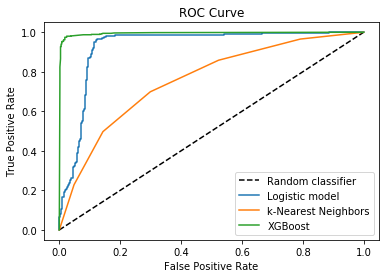

In [11]:
from sklearn.metrics import roc_curve
y_pred_prob = lr.predict_proba(X_test)[:,1]
y_pred_prob2 = knn.predict_proba(X_test)[:,1]
y_pred_prob3 = xgb.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test,y_pred_prob)
fpr2, tpr2, thresholds2 = roc_curve(y_test,y_pred_prob2)
fpr3, tpr3, thresholds3 = roc_curve(y_test,y_pred_prob3)
plot1, = plt.plot([0, 1], [0, 1], 'k--',label='Plot 1')
plot2, = plt.plot(fpr, tpr, label='Plot 2')
plot3, = plt.plot(fpr2,tpr2, label='Plot 3')
plot4, = plt.plot(fpr3,tpr3, label='Plot 4')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend([plot1,plot2,plot3,plot4],['Random classifier','Logistic model','k-Nearest Neighbors','XGBoost'])
plt.show()

## Wyznaczania pola pod wykresem wykresu ROC

In [12]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

print("AUC (model logistyczny): {}".format(roc_auc_score(y_test, y_pred_prob)))
print("AUC (model k-Nearest Neighbors): {}".format(roc_auc_score(y_test, y_pred_prob2)))
print("AUC (model XGBoost): {}".format(roc_auc_score(y_test, y_pred_prob3)))

AUC (model logistyczny): 0.9280793415094686
AUC (model k-Nearest Neighbors): 0.7571522851014684
AUC (model XGBoost): 0.9947386753194376


## Kroswalidacja

W celu bardziej wiarygodnej weryfikacji, zastosujmy również krosswalidację:

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn import svm
lr=LogisticRegression()
knn=KNeighborsClassifier()
xgb=XGBClassifier()
scores_log = cross_val_score(lr, voices_df[voices_df.columns.values[:-1]],voices_df[voices_df.columns.values[-1]], cv=10)
scores_knn = cross_val_score(knn, voices_df[voices_df.columns.values[:-1]],voices_df[voices_df.columns.values[-1]], cv=10)
scores_xgb = cross_val_score(xgb, voices_df[voices_df.columns.values[:-1]],voices_df[voices_df.columns.values[-1]], cv=10)
print(f'Średnia wyniku (model logistyczny): {np.mean(scores_log)}')
print(f'Odchylenie standardowe (model logistyczny): {np.std(scores_log)}')
print(f'Średnia wyniku (model k-Nearest Neighbors): {np.mean(scores_knn)}')
print(f'Odchylenie standardowe (model k-Nearest Neighbors): {np.std(scores_knn)}')
print(f'Średnia wyniku (model XGBoost): {np.mean(scores_xgb)}')
print(f'Odchylenie standardowe (model XGBoost): {np.std(scores_xgb)}')

Średnia wyniku (model logistyczny): 0.8721638781296172
Odchylenie standardowe (model logistyczny): 0.08681464562337544
Średnia wyniku (model k-Nearest Neighbors): 0.6707533043165754
Odchylenie standardowe (model k-Nearest Neighbors): 0.07812348676719197
Średnia wyniku (model XGBoost): 0.9681138441879966
Odchylenie standardowe (model XGBoost): 0.021642310483901608


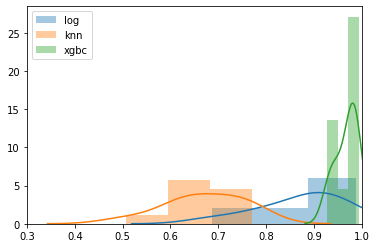

In [14]:
sns.distplot(scores_log, label="log")
sns.distplot(scores_knn, label="knn")
sns.distplot(scores_xgb, label="xgbc")

plt.xlim(0.3,1)
plt.legend()
plt.show()

Jak widzimy, model XGBoost zdecydowanie dystansuje pozostałe dwa. Zdecydowanie najsłabiej wypadł model k-Nearest Neighbors.